In [19]:
from google.colab import files
uploaded = files.upload()

LOG_FILE = list(uploaded.keys())[0]
print("File uploaded:", LOG_FILE)


Saving log-attack.txt to log-attack (2).txt
File uploaded: log-attack (2).txt


In [20]:
import re
import pandas as pd
import numpy as np

from dateutil import parser as dt
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns


In [21]:
# Regex
ip_regex = re.compile(r"\b\d{1,3}(?:\.\d{1,3}){3}\b")
user_regex = re.compile(r"(?:invalid user|user)\s+(\S+)")
port_regex = re.compile(r"port\s+(\d+)")
ts_regex = re.compile(r"^\S+")


In [22]:
events = []

with open(LOG_FILE, "r", encoding="utf-8", errors="ignore") as f:
    for line in f:
        ts_match = ts_regex.search(line)
        timestamp = dt.parse(ts_match.group()) if ts_match else None

        ip_match = ip_regex.search(line)
        ip = ip_match.group() if ip_match else None

        port_match = port_regex.search(line)
        port = port_match.group(1) if port_match else None

        # Username
        user_match = user_regex.search(line)
        user = user_match.group(1) if user_match else None

        if "Failed password" in line or "authentication failure" in line or "Invalid user" in line:
            event_type = "fail"
        elif "Accepted password" in line or "Accepted publickey" in line:
            event_type = "success"
        else:
            event_type = "other"

        if ip:
            events.append({
                "timestamp": timestamp,
                "ip": ip,
                "username": user,
                "port": port,
                "event": event_type,
                "raw": line.strip()
            })

df_raw = pd.DataFrame(events)
df_raw.head(10)


,timestamp,ip,username,port,event,raw
0,2025-10-18 08:21:51+07:00,45.159.112.142,None,None,fail,2025-10-18T08:21:51+07:00 TDC-250818413 sshd[7...
1,2025-10-18 08:21:54+07:00,45.159.112.142,user,33580,fail,2025-10-18T08:21:54+07:00 TDC-250818413 sshd[7...
2,2025-10-18 08:21:55+07:00,45.159.112.142,None,33580,other,2025-10-18T08:21:55+07:00 TDC-250818413 sshd[7...
3,2025-10-18 08:21:55+07:00,45.159.112.142,user,33580,other,2025-10-18T08:21:55+07:00 TDC-250818413 sshd[7...
4,2025-10-18 08:21:57+07:00,185.169.6.22,None,None,fail,2025-10-18T08:21:57+07:00 TDC-250818413 sshd[7...
5,2025-10-18 08:21:57+07:00,192.145.169.91,admin,60232,fail,2025-10-18T08:21:57+07:00 TDC-250818413 sshd[7...
6,2025-10-18 08:21:58+07:00,192.145.169.91,None,None,fail,2025-10-18T08:21:58+07:00 TDC-250818413 sshd[7...
7,2025-10-18 08:21:59+07:00,185.169.6.22,None,50754,fail,2025-10-18T08:21:59+07:00 TDC-250818413 sshd[7...
8,2025-10-18 08:22:00+07:00,192.145.169.91,admin,60232,fail,2025-10-18T08:22:00+07:00 TDC-250818413 sshd[7...
9,2025-10-18 08:22:01+07:00,185.169.6.22,None,50754,other,2025-10-18T08:22:01+07:00 TDC-250818413 sshd[7...


In [23]:
groups = df_raw.groupby("ip")
rows = []

for ip, g in groups:
    g = g.sort_values("timestamp")
    occ = len(g)
    fail = (g["event"]=="fail").sum()
    success = (g["event"]=="success").sum()

    unique_users = g["username"].nunique()
    unique_ports = g["port"].nunique()

    # convert timestamp về datetime64
    timestamps = g["timestamp"].dropna().values.astype("datetime64[ns]")

    # time span
    if len(timestamps) > 1:
        span = (timestamps[-1] - timestamps[0]) / np.timedelta64(1, "s")
    else:
        span = 0

    if len(timestamps) > 1:
        deltas = np.diff(timestamps) / np.timedelta64(1, "s")
        avg_interval = deltas.mean()
    else:
        avg_interval = 0

    attempts_per_min = occ / (span/60) if span > 0 else occ
    fail_ratio = fail / (occ+1)

    rows.append({
        "ip": ip,
        "occ_count": occ,
        "fail_count": fail,
        "success_count": success,
        "unique_users": unique_users,
        "unique_ports": unique_ports,
        "time_span": span,
        "avg_interval": avg_interval,
        "attempts_per_min": attempts_per_min,
        "fail_ratio": fail_ratio
    })

df_feat = pd.DataFrame(rows)
df_feat.head(10)


,ip,occ_count,fail_count,success_count,unique_users,unique_ports,time_span,avg_interval,attempts_per_min,fail_ratio
0,1.13.19.219,1,0,0,0,1,0.0,0.000000,1.000000,0.000000
1,1.54.152.53,1,0,1,0,1,0.0,0.000000,1.000000,0.000000
2,1.71.54.169,130,72,0,17,30,2139.0,16.581395,3.646564,0.549618
3,101.126.89.164,1,0,0,0,1,0.0,0.000000,1.000000,0.000000
4,101.89.186.252,1,0,0,0,1,0.0,0.000000,1.000000,0.000000
5,103.149.28.125,156,92,0,29,32,3608.0,23.277419,2.594235,0.585987
6,103.152.14.43,151,87,0,24,32,2963.0,19.753333,3.057712,0.572368
7,103.29.69.96,1,0,0,0,1,0.0,0.000000,1.000000,0.000000
8,103.63.25.115,156,92,0,26,32,3613.0,23.309677,2.590645,0.585987
9,103.67.78.49,142,80,0,23,32,3022.0,21.432624,2.819325,0.559441


In [24]:
df_feat["label"] = ( (df_feat.fail_count >= 20) & (df_feat.occ_count >= 30) ).astype(int)
df_feat.head()


,ip,occ_count,fail_count,success_count,unique_users,unique_ports,time_span,avg_interval,attempts_per_min,fail_ratio,label
0,1.13.19.219,1,0,0,0,1,0.0,0.000000,1.000000,0.000000,0
1,1.54.152.53,1,0,1,0,1,0.0,0.000000,1.000000,0.000000,0
2,1.71.54.169,130,72,0,17,30,2139.0,16.581395,3.646564,0.549618,1
3,101.126.89.164,1,0,0,0,1,0.0,0.000000,1.000000,0.000000,0
4,101.89.186.252,1,0,0,0,1,0.0,0.000000,1.000000,0.000000,0


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

features = [
    "occ_count", "fail_count", "success_count",
    "unique_users", "unique_ports",
    "time_span", "avg_interval", "attempts_per_min", "fail_ratio"
]

X = df_feat[features].values
y = df_feat["label"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.92      1.00      0.96        12
           1       1.00      0.94      0.97        18

    accuracy                           0.97        30
   macro avg       0.96      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30

Confusion matrix:
 [[12  0]
 [ 1 17]]


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train.reshape(-1,1), dtype=torch.float32)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test.reshape(-1,1), dtype=torch.float32)

class LogReg(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.linear = nn.Linear(dim, 1)
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

net = LogReg(X_train.shape[1])

criterion = nn.BCELoss()
opt = optim.Adam(net.parameters(), lr=0.01)

for epoch in range(2000):
    opt.zero_grad()
    out = net(X_train_t)
    loss = criterion(out, y_train_t)
    loss.backward()
    opt.step()
    if epoch % 200 == 0:
        print("Epoch:", epoch, "Loss:", loss.item())

with torch.no_grad():
    pred = (net(X_test_t) > 0.5).float()
    acc = (pred.eq(y_test_t).sum()/len(y_test_t)).item()

print("PyTorch Accuracy:", acc)


Epoch: 0 Loss: 0.5122501850128174
Epoch: 200 Loss: 0.07058902084827423
Epoch: 400 Loss: 0.037422094494104385
Epoch: 600 Loss: 0.025430437177419662
Epoch: 800 Loss: 0.01904193125665188
Epoch: 1000 Loss: 0.01500870380550623
Epoch: 1200 Loss: 0.012214161455631256
Epoch: 1400 Loss: 0.01016187947243452
Epoch: 1600 Loss: 0.008593343198299408
Epoch: 1800 Loss: 0.0073589361272752285
PyTorch Accuracy: 0.9666666388511658


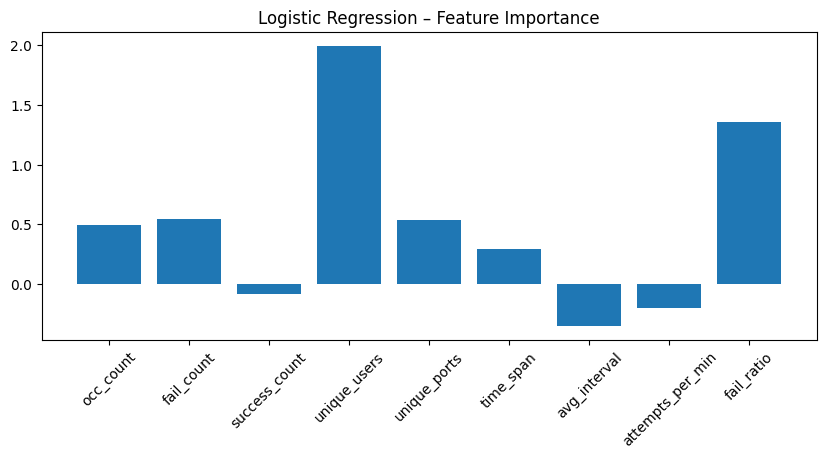

In [27]:
coef = model.coef_[0]
plt.figure(figsize=(10,4))
plt.bar(features, coef)
plt.xticks(rotation=45)
plt.title("Logistic Regression – Feature Importance")
plt.show()
